# Data Preparation for Scenario 1

## Generic Import and Settings

In [1]:
from pathlib import Path
import pandas as pd

## Load the data

In [2]:
raw_data_dir = Path().absolute().parent / "raw_data"

#### Weather data

In [3]:
wm = pd.read_csv(raw_data_dir / "weather_measurements.csv.bz2", index_col=0, parse_dates=True)
wm

,Temperature,Irradiance
2021-06-10 00:00:00+00:00,16.506667,0.492605
2021-06-10 00:15:00+00:00,16.626667,-0.145467
2021-06-10 00:30:00+00:00,16.620000,-2.935791
2021-06-10 00:45:00+00:00,16.293333,0.852966
2021-06-10 01:00:00+00:00,16.066667,1.560466
...,...,...
2021-10-03 22:45:00+00:00,14.040000,-0.168609
2021-10-03 23:00:00+00:00,13.813334,0.482687
2021-10-03 23:15:00+00:00,13.553333,3.239950
2021-10-03 23:30:00+00:00,13.406668,0.228119


#### Measured values in building

In [4]:
bd_all = pd.read_csv(raw_data_dir / "building_measurements.csv.bz2", index_col=0, parse_dates=True)
bd_all.describe()

,P_cool_cca,T_cool_cca_feed,T_cool_cca_return,T_room_g_1,T_room_g_2,T_room_f_1,T_room_f_2,T_room_s_1,T_room_s_2,P_heating,T_heating_feed,T_heating_return,T_amb,P_cool_server
count,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000,10953.000000
mean,-12.867615,20.773620,21.828905,23.242404,23.030300,23.643501,23.505815,23.873438,23.308844,0.269350,23.142680,23.026022,20.441937,5.941143
std,16.258108,1.669346,1.084093,1.395769,1.424695,1.456468,1.688798,1.583436,1.524762,2.018165,2.927415,2.721761,5.055400,1.777856
min,-69.166667,18.223333,19.830833,20.400000,15.780000,21.700000,20.080000,21.340000,19.686667,0.000000,20.494667,20.416667,5.800000,0.102000
25%,-30.013333,19.252667,21.373333,22.400000,22.200000,22.800000,22.400000,22.900000,22.400000,0.000000,21.880000,21.784000,16.860000,4.782667
50%,0.000000,21.322667,21.452667,23.000000,22.800000,23.213333,23.200000,23.400000,22.900000,0.000000,22.424667,22.316000,19.613333,5.804000
75%,0.000000,21.571333,21.594000,23.666667,23.300000,23.800000,23.971429,24.100000,23.600000,0.000000,23.025333,22.907333,23.986667,6.852667
max,60.188667,28.805333,28.258000,30.000000,29.400000,31.400000,29.700000,32.753333,30.600000,62.518667,43.404667,39.732000,36.280000,21.642667


## Check for missing data (1 = missing)

### Weather data
There is a larger missing patch (3 days) of weather data. This is too long to interpolate over, hence there are two seperate time slots here:
* "2021-06-10":"2021-07-08"
* "2021-07-13":"2021-10-02"

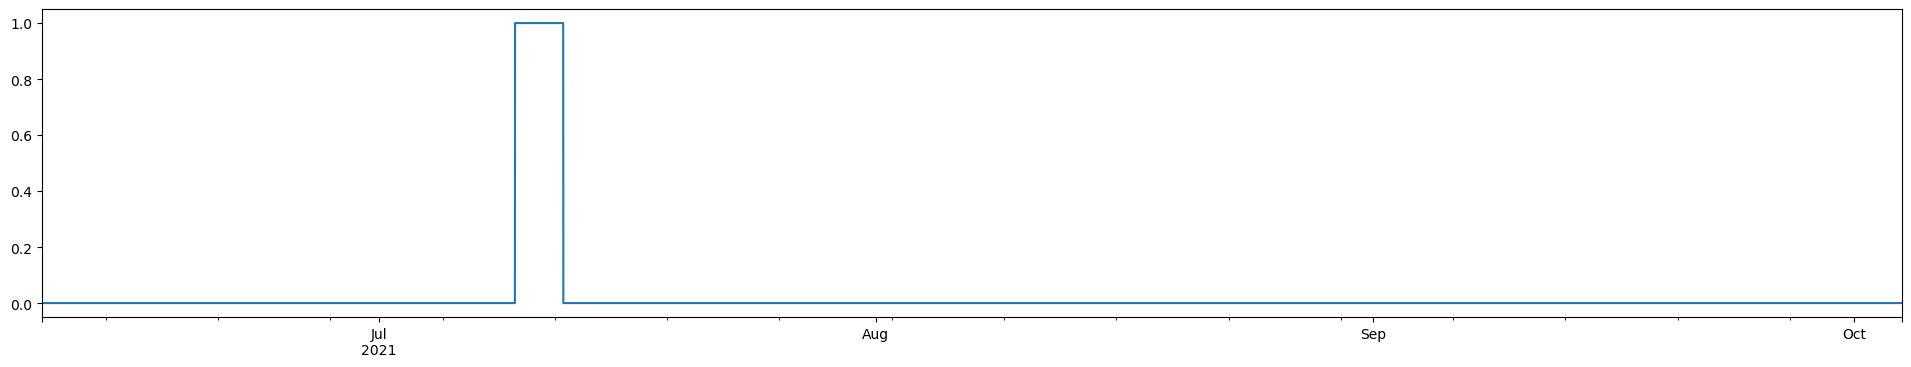

In [5]:
wm_missing_data = pd.isna(wm.resample("15T").mean()).any(axis=1) * 1
_ =  wm_missing_data.plot(figsize=(24,4))

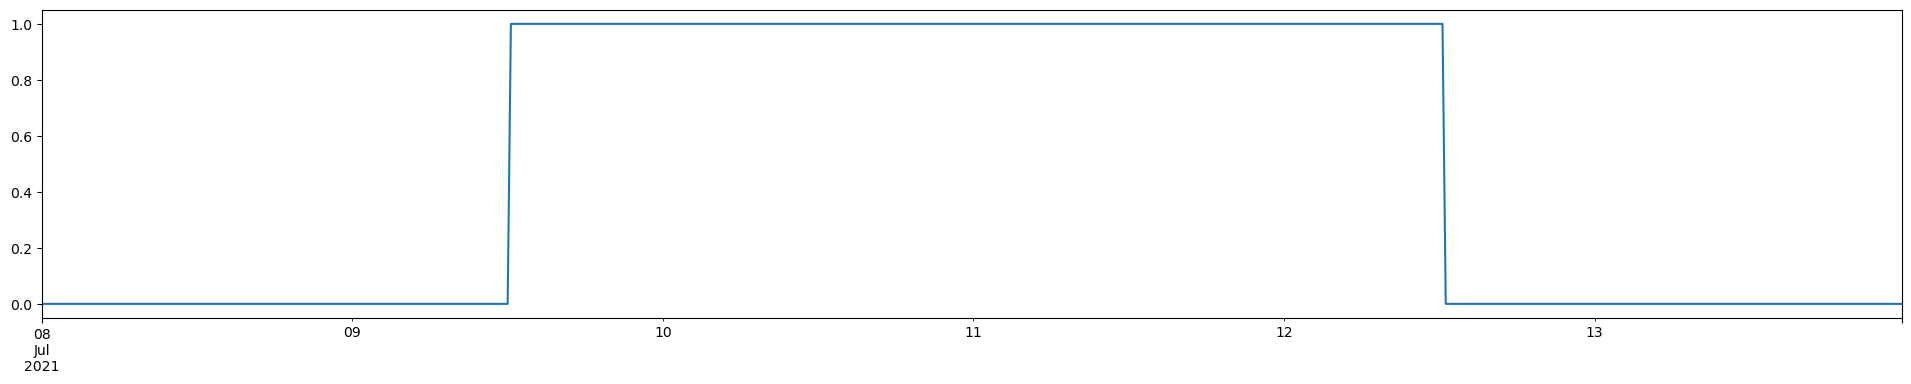

In [6]:
_ =  wm_missing_data.loc["2021-07-08":"2021-07-13"].plot(figsize=(24,4))

In [7]:
wm = wm["2021-07-13":"2021-10-02"].copy()

# Interpolate over any missing timestamps.
wm = wm.resample("15T").mean().interpolate(method="linear")

wm

,Temperature,Irradiance
2021-07-13 00:00:00+00:00,18.860000,4.244995
2021-07-13 00:15:00+00:00,18.693333,-0.327301
2021-07-13 00:30:00+00:00,18.580000,4.301199
2021-07-13 00:45:00+00:00,18.513333,2.380371
2021-07-13 01:00:00+00:00,18.626667,4.195404
...,...,...
2021-10-02 22:45:00+00:00,15.913333,1.910909
2021-10-02 23:00:00+00:00,15.453333,-1.054637
2021-10-02 23:15:00+00:00,15.493334,-2.373759
2021-10-02 23:30:00+00:00,15.340000,3.167216


### Building data
Three smaller patches of missing data in september. The larger ones roughly 9-12 hours. Not very nice, but should be OK to interpolate over.

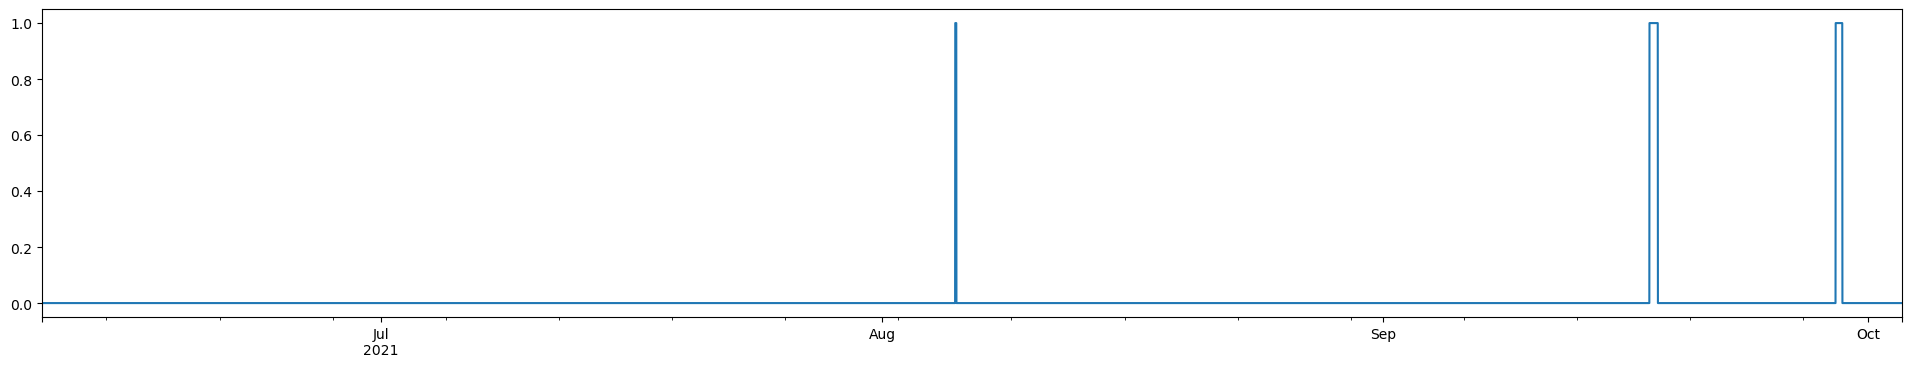

In [8]:
bd_missing_data = pd.isna(bd_all.resample("15T").mean()).any(axis=1) * 1
_ =  bd_missing_data.plot(figsize=(24,4))

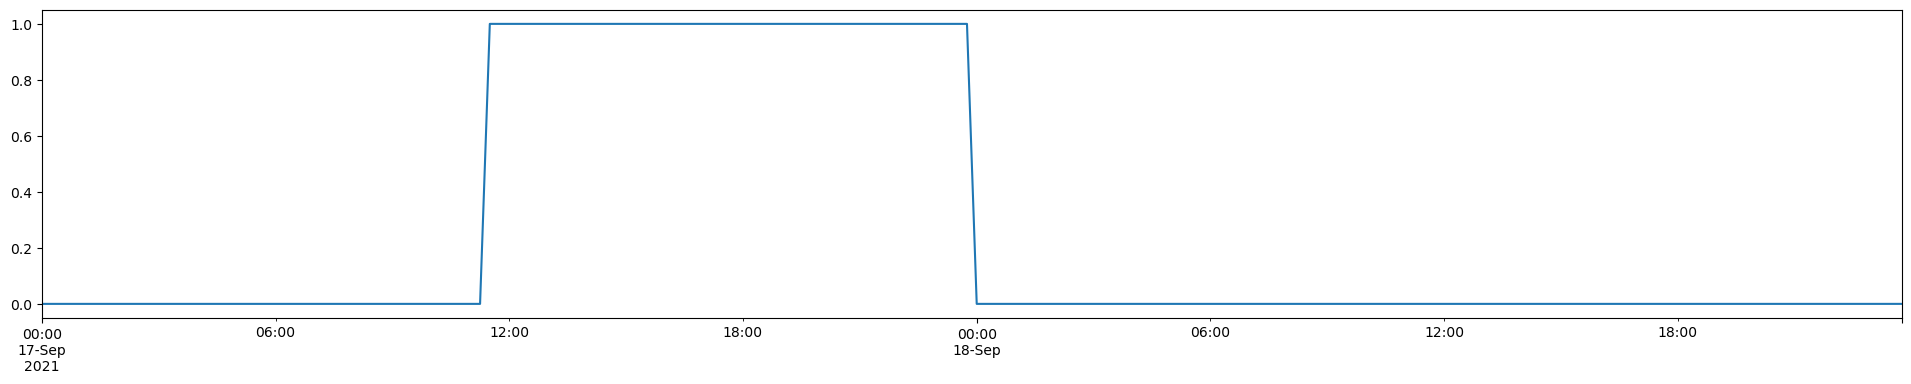

In [9]:
_ =  bd_missing_data.loc["2021-09-17":"2021-09-18"].plot(figsize=(24,4))

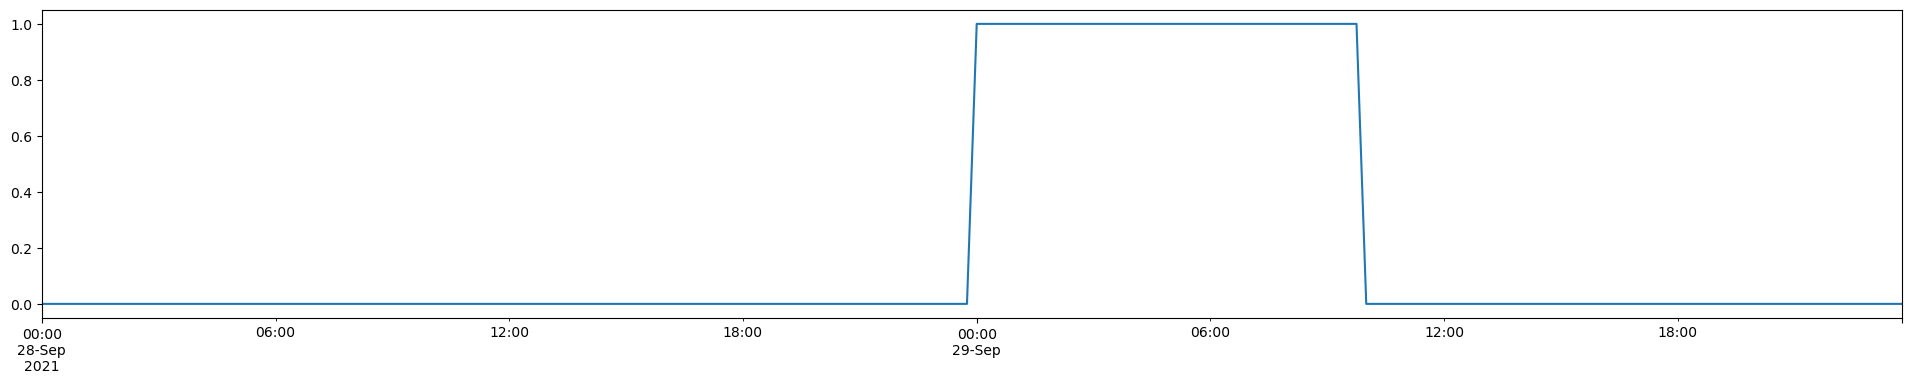

In [10]:
_ =  bd_missing_data.loc["2021-09-28":"2021-09-29"].plot(figsize=(24,4))

In [11]:
bd = bd_all["2021-07-13":"2021-10-02"].copy()

# Add UTC to index to prevent errors as wm is timezone aware.
bd.index = bd.index.tz_localize("utc")

# Interpolate over any missing timestamps.
bd = bd.resample("15T").mean().interpolate(method="linear")

bd

,P_cool_cca,T_cool_cca_feed,T_cool_cca_return,T_room_g_1,T_room_g_2,T_room_f_1,T_room_f_2,T_room_s_1,T_room_s_2,P_heating,T_heating_feed,T_heating_return,T_amb,P_cool_server
2021-07-13 00:00:00+00:00,-34.734667,18.518000,21.373333,23.400000,23.300000,23.40,23.700000,23.586667,23.000000,0.000000,22.908000,22.800667,20.466667,3.753333
2021-07-13 00:15:00+00:00,-33.730667,18.540000,21.352667,23.400000,23.300000,23.40,23.700000,23.500000,23.000000,0.000000,22.902667,22.794667,20.366667,4.392000
2021-07-13 00:30:00+00:00,-8.393333,20.716667,21.340667,23.400000,23.300000,23.34,23.700000,23.500000,22.953333,0.000000,22.901333,22.798000,20.300000,4.822000
2021-07-13 00:45:00+00:00,0.000000,21.413333,21.363333,23.400000,23.286667,23.30,23.686667,23.500000,22.900000,0.000000,22.900667,22.792667,20.206667,6.622667
2021-07-13 01:00:00+00:00,0.000000,21.443333,21.397333,23.300000,23.200000,23.30,23.600000,23.486667,22.900000,0.000000,22.898667,22.794000,20.100000,6.134000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02 22:45:00+00:00,0.000000,22.772000,22.505333,22.500000,22.200000,22.70,22.000000,23.500000,22.200000,2.818667,31.401333,30.876667,16.093333,3.130667
2021-10-02 23:00:00+00:00,1.173333,22.591333,22.454000,22.500000,22.200000,22.70,22.000000,23.500000,22.200000,0.000000,30.667333,30.678667,15.860000,4.422000
2021-10-02 23:15:00+00:00,1.704667,22.574000,22.455333,22.500000,22.200000,22.70,22.000000,23.500000,22.200000,0.000000,30.438667,30.456667,15.686667,4.935333
2021-10-02 23:30:00+00:00,0.836667,22.514667,22.461333,22.500000,22.200000,22.70,22.000000,23.500000,22.200000,0.000000,30.228667,30.239333,15.540000,3.990000


## Reduce Building Data
That is, build the variables required for the env.

Note that the heating went into operation at some days in early october. Let's get rid of these.

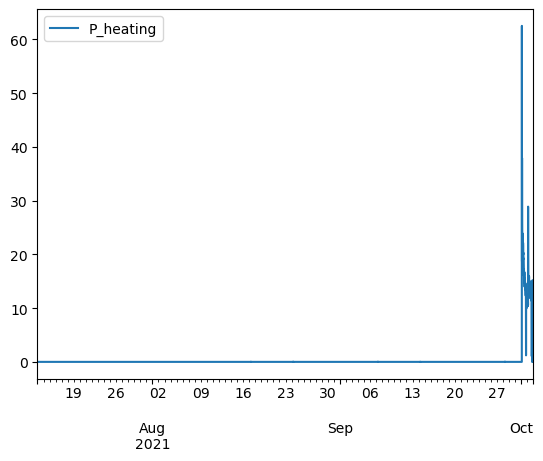

In [12]:
_ = bd[["P_heating"]].plot()

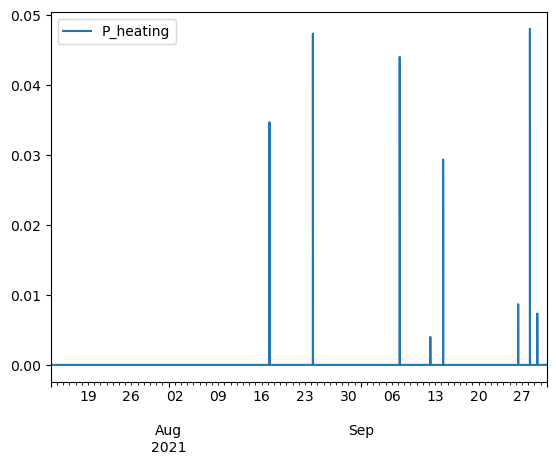

In [13]:
bd = bd[:"2021-09-30"]
_ = bd[["P_heating"]].plot()

These spikes are likely measurement errors and thus neglected.

In [14]:
bd = pd.DataFrame(
    index=bd.index,
    data={
        # Average over room measurements to get something like a zone temperature.
        "T_zone_s": 0.5 * (bd["T_room_s_1"] + bd["T_room_s_2"]),
        "T_zone_f": 0.5 * (bd["T_room_f_1"] + bd["T_room_f_2"]),
        "T_zone_g": 0.5 * (bd["T_room_g_1"] + bd["T_room_g_2"]),
        # This is in kW.
        "P_cool_cca": bd["P_cool_cca"],
    }
)

In [15]:
bd

,T_zone_s,T_zone_f,T_zone_g,P_cool_cca
2021-07-13 00:00:00+00:00,23.293333,23.550000,23.350000,-34.734667
2021-07-13 00:15:00+00:00,23.250000,23.550000,23.350000,-33.730667
2021-07-13 00:30:00+00:00,23.226667,23.520000,23.350000,-8.393333
2021-07-13 00:45:00+00:00,23.200000,23.493333,23.343333,0.000000
2021-07-13 01:00:00+00:00,23.193333,23.450000,23.250000,0.000000
...,...,...,...,...
2021-09-30 22:45:00+00:00,21.953333,21.990000,21.236667,0.000000
2021-09-30 23:00:00+00:00,21.950000,21.950000,21.200000,0.000000
2021-09-30 23:15:00+00:00,21.950000,21.950000,21.200000,0.000000
2021-09-30 23:30:00+00:00,21.906667,21.950000,21.200000,0.000000


### Export for Env to Use

In [16]:
data_dir = raw_data_dir.parent / "source" / "tbmenv" / "data"

In [17]:
scenario_data = pd.concat([bd, wm], axis=1).loc[bd.index]
scenario_data

,T_zone_s,T_zone_f,T_zone_g,P_cool_cca,Temperature,Irradiance
2021-07-13 00:00:00+00:00,23.293333,23.550000,23.350000,-34.734667,18.860000,4.244995
2021-07-13 00:15:00+00:00,23.250000,23.550000,23.350000,-33.730667,18.693333,-0.327301
2021-07-13 00:30:00+00:00,23.226667,23.520000,23.350000,-8.393333,18.580000,4.301199
2021-07-13 00:45:00+00:00,23.200000,23.493333,23.343333,0.000000,18.513333,2.380371
2021-07-13 01:00:00+00:00,23.193333,23.450000,23.250000,0.000000,18.626667,4.195404
...,...,...,...,...,...,...
2021-09-30 22:45:00+00:00,21.953333,21.990000,21.236667,0.000000,6.820000,4.347483
2021-09-30 23:00:00+00:00,21.950000,21.950000,21.200000,0.000000,6.786667,1.795196
2021-09-30 23:15:00+00:00,21.950000,21.950000,21.200000,0.000000,6.646667,1.295980
2021-09-30 23:30:00+00:00,21.906667,21.950000,21.200000,0.000000,6.933333,-3.325907


In [18]:
scenario_data.to_csv(data_dir / "scenario_1_data.csv.bz2")